正在生成目标频谱... 带宽 = 1.0 GHz
开始优化 5 个参数 (3个上臂环, 2个下臂环)...
目标带宽: 1.0 GHz
differential_evolution step 1: f(x)= 792.2865898114213
differential_evolution step 2: f(x)= 792.2865898114213
differential_evolution step 3: f(x)= 792.2865898114213
differential_evolution step 4: f(x)= 792.2865898114213
differential_evolution step 5: f(x)= 792.2865898114213
differential_evolution step 6: f(x)= 792.2865898114213
differential_evolution step 7: f(x)= 783.8806501750587
differential_evolution step 8: f(x)= 783.8806501750587
differential_evolution step 9: f(x)= 783.8806501750587
differential_evolution step 10: f(x)= 783.8806501750587
differential_evolution step 11: f(x)= 783.8806501750587
differential_evolution step 12: f(x)= 783.8806501750587
differential_evolution step 13: f(x)= 781.6790251064108
differential_evolution step 14: f(x)= 781.6790251064108
differential_evolution step 15: f(x)= 781.6790251064108
differential_evolution step 16: f(x)= 781.6790251064108
differential_evolution step 17: f(x)= 781.679

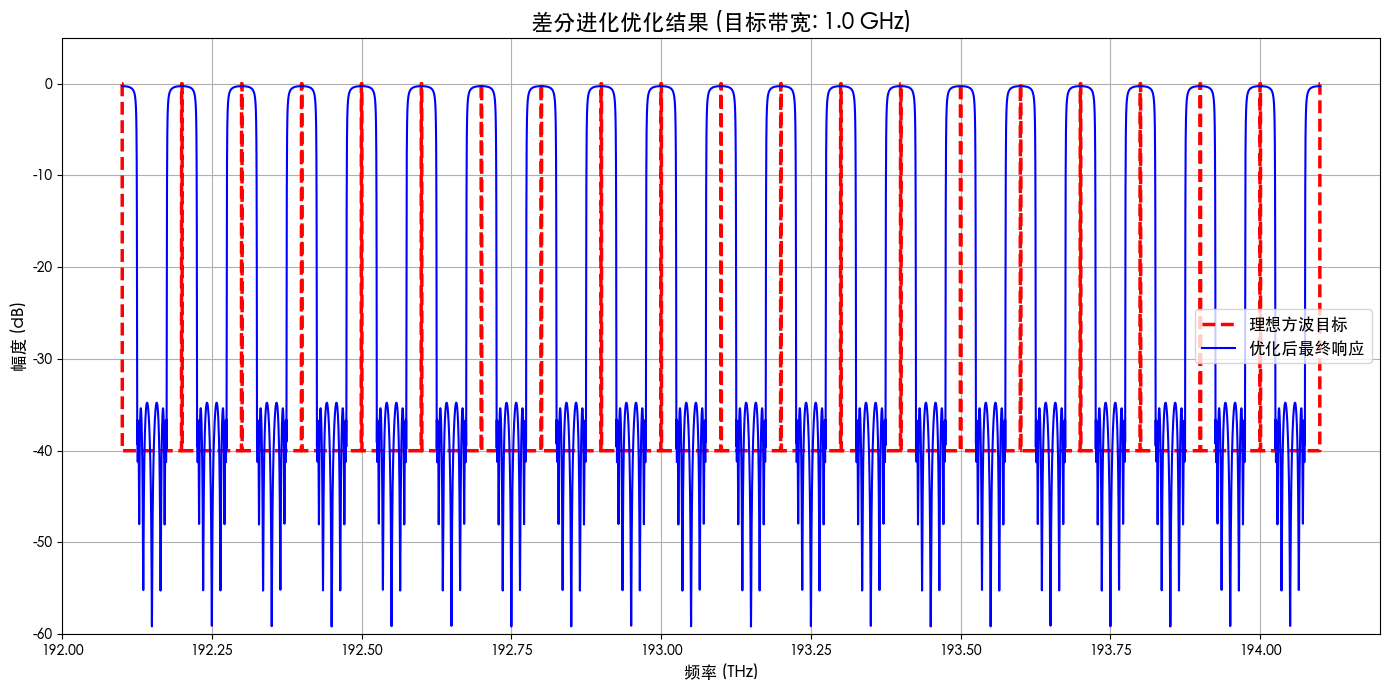

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

# ===================================================================
#                      核心仿真函数
# (您原来的这部分函数是正确的，无需改动)
# ===================================================================

def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def mrr_transfer_function(w, t, k, phi_offset):
    j = 1j
    numerator = np.sqrt(1 - k) - t**2 * np.exp(-j * (2*w + phi_offset))
    denominator = 1 - t**2 * np.sqrt(1 - k) * np.exp(-j * (2*w + phi_offset))
    return numerator / denominator

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):
    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db
    return reference_signal

def optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl):
    ku_params = params[:n_ku]
    kl_params = params[n_ku:]
    len_w = len(w_range)

    # 计算上臂 Au 的响应
    Au_mrr_responses = [mrr_transfer_function(w_range, t, k, phi_offset=np.pi) for k in ku_params]
    Au = np.prod(Au_mrr_responses, axis=0)
    
    # 计算下臂 Al 的响应
    if m_kl > 0:
        Al_mrr_responses = [mrr_transfer_function(w_range, t, k, phi_offset=np.pi) for k in kl_params]
        Al_mrr_product = np.prod(Al_mrr_responses, axis=0)
    else:
        Al_mrr_product = 1.0

    Al = Al_mrr_product * delay_line(w_range, t, delay=1.0, phi_c=0.0)

    H2_stack = np.zeros((len_w, 2, 2), dtype=complex)
    H2_stack[:, 0, 0] = Au
    H2_stack[:, 1, 1] = Al

    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    
    # 防止 log10(0) 警告
    H11_abs = np.abs(H11)
    H11_abs[H11_abs < 1e-15] = 1e-15
    
    return 20 * np.log10(H11_abs)

def objective_function(params, target_spectrum_db, t, w_range, H1, H3, n_ku, m_kl):
    simulated_spectrum = optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl)
    mse_loss = np.mean((simulated_spectrum - target_spectrum_db)**2)
    return mse_loss

if __name__ == "__main__":
    
    # ===================================================================
    #                  用户自定义仿真参数 (USER-DEFINED PARAMETERS)
    # ===================================================================
    n_ku = 3  # 上臂的微环数量
    m_kl = 2  # 下臂的微环数量
    
    # --- 新增：可控制的目标带宽 (单位: Hz) ---
    # --- 您可以在这里修改想要的带宽，例如 30e9 (30 GHz), 50e9 (50 GHz) 等 ---
    target_bandwidth = 1e9 
    
    # 物理和仿真常量
    f_center = 193.1e12
    fsr = 100e9
    s = 10
    t = 0.979888
    theta_i = np.pi / 2
    theta_o = np.pi / 2
    phi_t = 0.0
    phi_b = 0.0
    
    # 预计算频率数组
    w1 = -20 * np.pi
    w2 = 20 * np.pi
    dw = 0.006285
    w_range = np.arange(w1, w2, dw)
    len_w = len(w_range)
    frequency_f = np.linspace(f_center - s * fsr, f_center + s * fsr, len_w)
    
    # 预计算不变的矩阵 H1 和 H3
    Hi = tunable_mzi_in(theta_i)
    Hp = phase_shifter_matrix(phi_t, phi_b)
    H1 = Hi @ Hp
    H3 = tunable_mzi_out(theta_o)
    
    # ===================================================================
    #       【核心改动】使用上面的变量动态生成目标频谱
    # ===================================================================
    print(f"正在生成目标频谱... 带宽 = {target_bandwidth/1e9:.1f} GHz")
    target_spectrum = create_reference_box_filter(
        frequency_array=frequency_f,
        center_freq=f_center,
        fsr=fsr,
        bandwidth=target_bandwidth, # <-- 使用变量代替固定值
        passband_level_db=0,
        stopband_level_db=-40
    )
    
    total_params = n_ku + m_kl
    bounds = [(0, 1)] * total_params # 耦合系数 k 的范围是 [0, 1]

    args_for_optimizer = (target_spectrum, t, w_range, H1, H3, n_ku, m_kl)

    # 运行差分进化优化器
    print("="*50)
    print(f"开始优化 {total_params} 个参数 ({n_ku}个上臂环, {m_kl}个下臂环)...")
    print(f"目标带宽: {target_bandwidth/1e9:.1f} GHz")
    print("="*50)
    
    start_time = time.time()
    
    result = differential_evolution(
        objective_function, 
        bounds, 
        args=args_for_optimizer, 
        maxiter=300,
        popsize=20,
        disp=True,
    )
    
    end_time = time.time()
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")
    
    print("\n" + "="*50)
    print("优化结果详情:")
    print(f"  - 目标带宽: {target_bandwidth/1e9:.1f} GHz")
    print(f"  - 最低损失值 (MSE): {result.fun:.4f}")
    best_params = result.x
    
    print(f"  - 找到的最佳参数 ({total_params}个):")
    for i in range(n_ku):
        print(f"    ku{i+1} = {best_params[i]:.4f}")
    for i in range(m_kl):
        print(f"    kl{i+1} = {best_params[n_ku + i]:.4f}")
    print("="*50)
    
    # 使用找到的最佳参数进行最终验证
    print("\n正在使用找到的最佳参数进行最终效果验证...")
    final_spectrum_db = optical_simulation(best_params, t, w_range, H1, H3, n_ku, m_kl)

    # 绘图对比
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_f / 1e12, target_spectrum, 'r--', lw=2.5, label='理想方波目标')
    plt.plot(frequency_f / 1e12, final_spectrum_db, 'b-', lw=1.5, label='优化后最终响应')
    
    # 动态标题，包含带宽信息
    title_text = f'差分进化优化结果 (目标带宽: {target_bandwidth/1e9:.1f} GHz)'
    plt.title(title_text, fontsize=16)
    plt.xlabel('频率 (THz)', fontsize=12)
    plt.ylabel('幅度 (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

开始优化 2 个参数 (1个k值, 1个L值)...
目标带宽: 10.0 GHz
differential_evolution step 1: f(x)= 900.9067617523052
differential_evolution step 2: f(x)= 888.9691783091871
differential_evolution step 3: f(x)= 851.366373259838
differential_evolution step 4: f(x)= 824.2168086680024
differential_evolution step 5: f(x)= 824.2168086680024
differential_evolution step 6: f(x)= 807.5085987789157
differential_evolution step 7: f(x)= 802.6916404659515
differential_evolution step 8: f(x)= 792.5941129196907
differential_evolution step 9: f(x)= 792.5941129196907
differential_evolution step 10: f(x)= 792.5941129196907
differential_evolution step 11: f(x)= 792.5941129196907
differential_evolution step 12: f(x)= 790.3511602918927
differential_evolution step 13: f(x)= 790.3511602918927
differential_evolution step 14: f(x)= 790.3511602918927
Polishing solution with 'L-BFGS-B'

优化完成！总耗时: 1.49 秒

优化结果详情:
  - 目标带宽: 10.0 GHz
  - 最低损失值 (MSE): 789.9548
  - 找到的最佳参数 (2个):
    --- 耦合系数 k ---
      ku1_k = 0.8094
    --- 归一化长度 L_nor

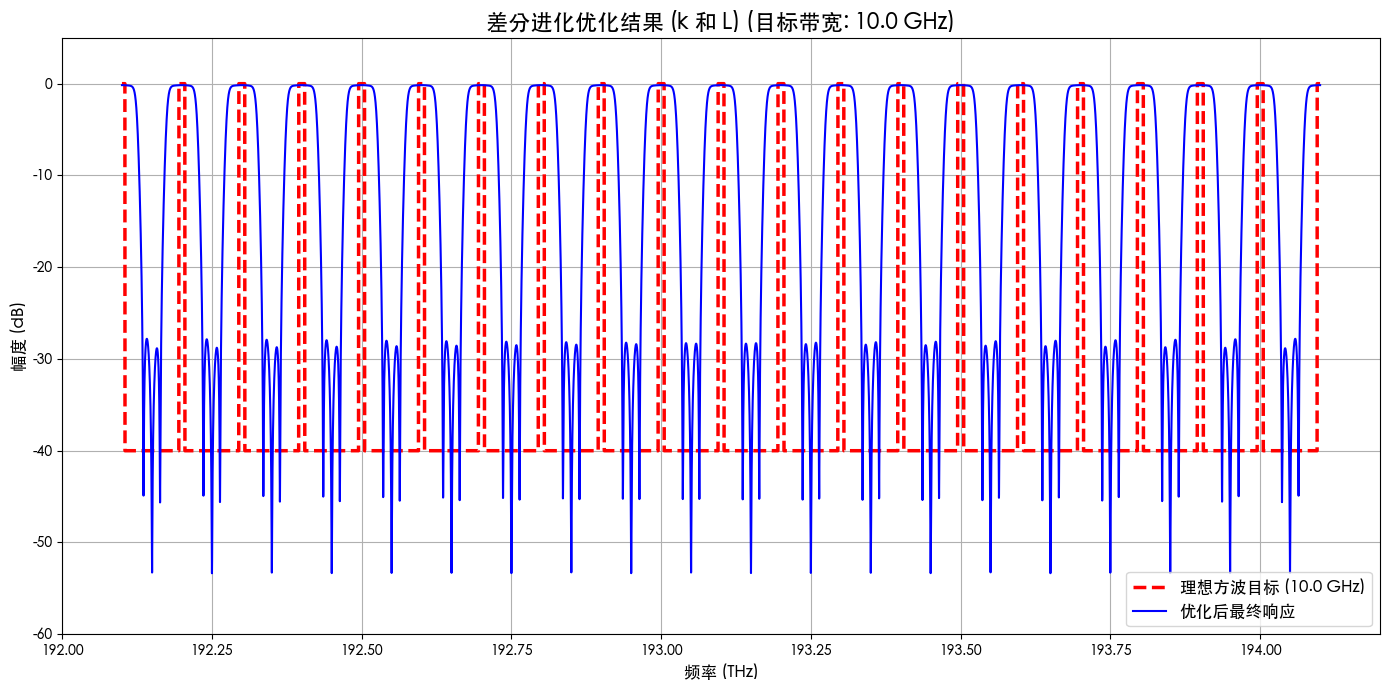

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

# (其他函数如 tunable_mzi_in, phase_shifter_matrix 等保持不变)
def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):
    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db
    return reference_signal

# ===================================================================
#                      【改动 1】修改微环传递函数
# ===================================================================
# 增加 L_norm 参数，它是一个归一化的长度因子，用于调整环路相位延迟
def mrr_transfer_function(w, t, k, L_norm, phi_offset):
    j = 1j
    # 核心改动：在相位项中乘以 L_norm，模拟环路长度的变化
    phase_term = np.exp(-j * (L_norm * 2*w + phi_offset))
    
    numerator = np.sqrt(1 - k) - t**2 * phase_term
    denominator = 1 - t**2 * np.sqrt(1 - k) * phase_term
    return numerator / denominator

# ===================================================================
#                      【改动 2】修改光学仿真函数
# ===================================================================
# 现在 params 数组包含 k 值和 L_norm 值
def optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl):
    
    num_rings = n_ku + m_kl
    # 前 num_rings 个是 k 参数
    k_params = params[:num_rings]
    # 后 num_rings 个是 L_norm 参数
    L_params = params[num_rings:]

    ku_k_params = k_params[:n_ku]
    kl_k_params = k_params[n_ku:]
    
    ku_L_params = L_params[:n_ku]
    kl_L_params = L_params[n_ku:]
    
    len_w = len(w_range)

    # 计算上臂 Au 的响应
    Au_mrr_responses = [mrr_transfer_function(w_range, t, ku_k_params[i], ku_L_params[i], phi_offset=np.pi) for i in range(n_ku)]
    Au = np.prod(Au_mrr_responses, axis=0)
    
    # 计算下臂 Al 的响应
    if m_kl > 0:
        Al_mrr_responses = [mrr_transfer_function(w_range, t, kl_k_params[i], kl_L_params[i], phi_offset=np.pi) for i in range(m_kl)]
        Al_mrr_product = np.prod(Al_mrr_responses, axis=0)
    else:
        Al_mrr_product = 1.0

    Al = Al_mrr_product * delay_line(w_range, t, delay=1.0, phi_c=0.0)

    H2_stack = np.zeros((len_w, 2, 2), dtype=complex)
    H2_stack[:, 0, 0] = Au
    H2_stack[:, 1, 1] = Al

    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    
    H11_abs = np.abs(H11)
    H11_abs[H11_abs < 1e-15] = 1e-15
    
    return 20 * np.log10(H11_abs)

def objective_function(params, target_spectrum_db, t, w_range, H1, H3, n_ku, m_kl):
    simulated_spectrum = optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl)
    mse_loss = np.mean((simulated_spectrum - target_spectrum_db)**2)
    return mse_loss

if __name__ == "__main__":
    
    # 用户自定义仿真参数
    n_ku = 1
    m_kl = 0
    target_bandwidth = 10e9 # 尝试 10 GHz
    
    # 物理和仿真常量... (保持不变)
    f_center = 193.1e12
    fsr = 100e9
    s = 10
    t = 0.979888
    theta_i = np.pi / 2
    theta_o = np.pi / 2
    phi_t = 0.0
    phi_b = 0.0
    
    # 频率数组... (保持不变)
    w1 = -20 * np.pi
    w2 = 20 * np.pi
    dw = 0.006285
    w_range = np.arange(w1, w2, dw)
    len_w = len(w_range)
    frequency_f = np.linspace(f_center - s * fsr, f_center + s * fsr, len_w)
    
    # 矩阵 H1, H3 和目标频谱... (保持不变)
    Hi = tunable_mzi_in(theta_i)
    Hp = phase_shifter_matrix(phi_t, phi_b)
    H1 = Hi @ Hp
    H3 = tunable_mzi_out(theta_o)
    target_spectrum = create_reference_box_filter(frequency_f, f_center, fsr, target_bandwidth, 0, -40)

    # ===================================================================
    #                      【改动 3】更新优化器设置
    # ===================================================================
    num_rings = n_ku + m_kl
    total_params = 2 * num_rings # 参数总数加倍 (k 和 L)

    # 为 k 和 L_norm 设置不同的边界
    bounds_k = [(0.01, 0.99)] * num_rings  # k 的边界，避免0和1
    # 允许环路长度在基准长度附近 +/- 20% 范围内变化
    bounds_L = [(0.8, 1.2)] * num_rings  
    
    bounds = bounds_k + bounds_L

    args_for_optimizer = (target_spectrum, t, w_range, H1, H3, n_ku, m_kl)

    # 运行差分进化优化器
    print("="*50)
    print(f"开始优化 {total_params} 个参数 ({num_rings}个k值, {num_rings}个L值)...")
    print(f"目标带宽: {target_bandwidth/1e9:.1f} GHz")
    print("="*50)
    
    start_time = time.time()
    
    # 注意：优化难度增加，可能需要更多迭代次数或更大的种群
    result = differential_evolution(
        objective_function, 
        bounds, 
        args=args_for_optimizer, 
        maxiter=400,  # 增加迭代次数
        popsize=20,   # 增加种群大小
        disp=True,
    )
    
    end_time = time.time()
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")
    
    # 打印结果
    print("\n" + "="*50)
    print("优化结果详情:")
    print(f"  - 目标带宽: {target_bandwidth/1e9:.1f} GHz")
    print(f"  - 最低损失值 (MSE): {result.fun:.4f}")
    best_params = result.x
    
    best_k = best_params[:num_rings]
    best_L = best_params[num_rings:]
    
    print(f"  - 找到的最佳参数 ({total_params}个):")
    print("    --- 耦合系数 k ---")
    for i in range(n_ku):
        print(f"      ku{i+1}_k = {best_k[i]:.4f}")
    for i in range(m_kl):
        print(f"      kl{i+1}_k = {best_k[n_ku + i]:.4f}")
    print("    --- 归一化长度 L_norm ---")
    for i in range(n_ku):
        print(f"      ku{i+1}_L = {best_L[i]:.4f}")
    for i in range(m_kl):
        print(f"      kl{i+1}_L = {best_L[n_ku + i]:.4f}")
    print("="*50)
    
    # 最终效果验证与绘图... (保持不变)
    final_spectrum_db = optical_simulation(best_params, t, w_range, H1, H3, n_ku, m_kl)
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_f / 1e12, target_spectrum, 'r--', lw=2.5, label=f'理想方波目标 ({target_bandwidth/1e9:.1f} GHz)')
    plt.plot(frequency_f / 1e12, final_spectrum_db, 'b-', lw=1.5, label='优化后最终响应')
    title_text = f'差分进化优化结果 (k 和 L) (目标带宽: {target_bandwidth/1e9:.1f} GHz)'
    plt.title(title_text, fontsize=16)
    plt.xlabel('频率 (THz)', fontsize=12)
    plt.ylabel('幅度 (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

正在生成目标频谱... 带宽 = 5.0 GHz, FSR = 10.0 GHz
开始优化 2 个参数... 目标: 5.0GHz带宽 / 10.0GHz FSR
differential_evolution step 1: f(x)= 448.9246992414555
differential_evolution step 2: f(x)= 448.9246992414555
differential_evolution step 3: f(x)= 448.9246992414555
differential_evolution step 4: f(x)= 415.09182894686376
differential_evolution step 5: f(x)= 415.09182894686376
differential_evolution step 6: f(x)= 415.09182894686376
differential_evolution step 7: f(x)= 415.09182894686376
differential_evolution step 8: f(x)= 384.0811031979514
differential_evolution step 9: f(x)= 384.0811031979514
differential_evolution step 10: f(x)= 384.0811031979514
differential_evolution step 11: f(x)= 379.7654328537014
differential_evolution step 12: f(x)= 374.68938867691963
differential_evolution step 13: f(x)= 340.5372323278546
differential_evolution step 14: f(x)= 239.28553235512203
differential_evolution step 15: f(x)= 187.59266419460758
differential_evolution step 16: f(x)= 176.61481096416318
differential_evolution 

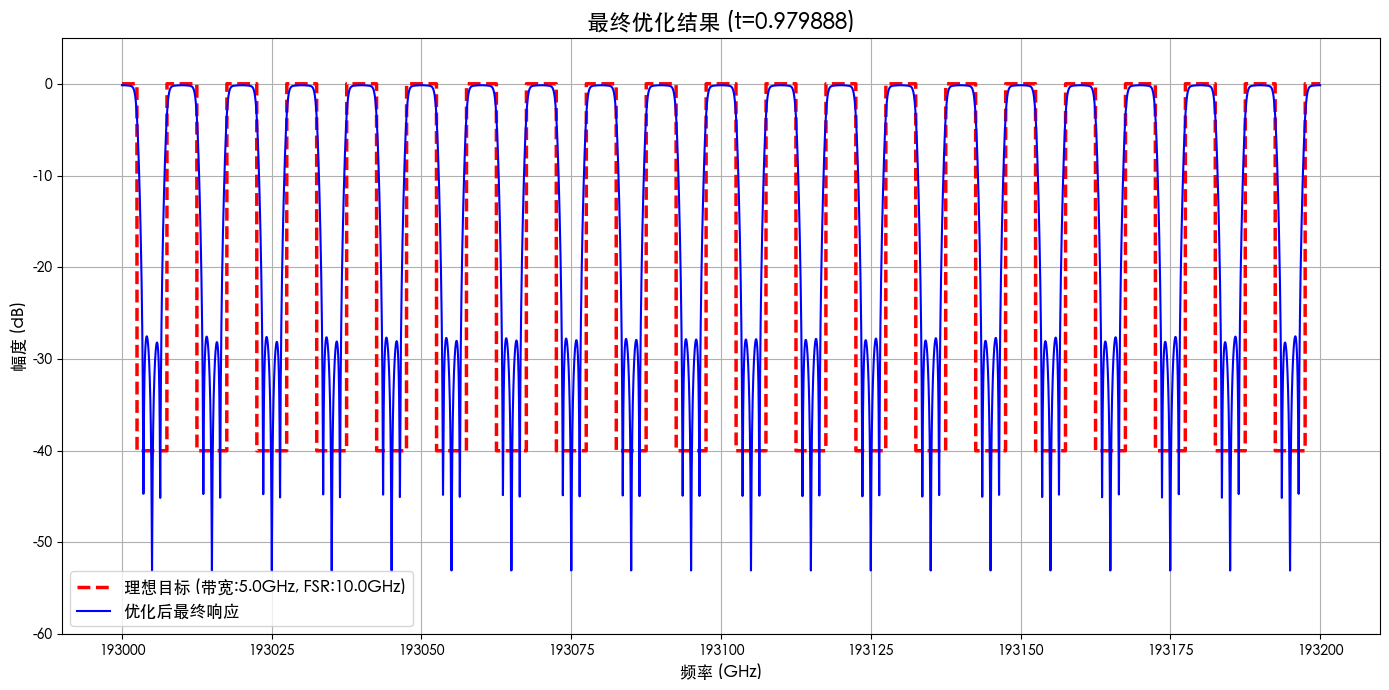

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

# ... [从tunable_mzi_in 到 objective_function 的所有函数保持不变，这里省略以保持简洁] ...
# ... [请确保您使用的是我们之前修改过的，带有 L_norm 参数的 mrr_transfer_function 和 optical_simulation 函数] ...
def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)

def create_reference_box_filter(frequency_array, center_freq, fsr, bandwidth, passband_level_db, stopband_level_db):
    reference_signal = np.full_like(frequency_array, stopband_level_db)
    f_offset = frequency_array - center_freq
    f_normalized = np.mod(f_offset + fsr / 2, fsr) - fsr / 2
    passband_mask = np.abs(f_normalized) <= (bandwidth / 2)
    reference_signal[passband_mask] = passband_level_db
    return reference_signal

def mrr_transfer_function(w, t, k, L_norm, phi_offset):
    j = 1j
    phase_term = np.exp(-j * (L_norm * 2*w + phi_offset))
    numerator = np.sqrt(1 - k) - t**2 * phase_term
    denominator = 1 - t**2 * np.sqrt(1 - k) * phase_term
    return numerator / denominator

def optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl):
    num_rings = n_ku + m_kl
    k_params = params[:num_rings]
    L_params = params[num_rings:]
    ku_k_params, kl_k_params = k_params[:n_ku], k_params[n_ku:]
    ku_L_params, kl_L_params = L_params[:n_ku], L_params[n_ku:]
    len_w = len(w_range)
    Au_mrr_responses = [mrr_transfer_function(w_range, t, ku_k_params[i], ku_L_params[i], phi_offset=np.pi) for i in range(n_ku)]
    Au = np.prod(Au_mrr_responses, axis=0)
    if m_kl > 0:
        Al_mrr_responses = [mrr_transfer_function(w_range, t, kl_k_params[i], kl_L_params[i], phi_offset=np.pi) for i in range(m_kl)]
        Al_mrr_product = np.prod(Al_mrr_responses, axis=0)
    else:
        Al_mrr_product = 1.0
    Al = Al_mrr_product * delay_line(w_range, t, delay=1.0, phi_c=0.0)
    H2_stack = np.zeros((len_w, 2, 2), dtype=complex)
    H2_stack[:, 0, 0], H2_stack[:, 1, 1] = Au, Al
    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    H11_abs = np.abs(H11)
    H11_abs[H11_abs < 1e-15] = 1e-15
    return 20 * np.log10(H11_abs)

def objective_function(params, target_spectrum_db, t, w_range, H1, H3, n_ku, m_kl):
    simulated_spectrum = optical_simulation(params, t, w_range, H1, H3, n_ku, m_kl)
    mse_loss = np.mean((simulated_spectrum - target_spectrum_db)**2)
    return mse_loss

if __name__ == "__main__":
    
    # ===================================================================
    #                  核心设计参数 (MASTER CONTROL PANEL)
    # ===================================================================
    # 1. 结构参数
    n_ku = 1  # 上臂的微环数量
    m_kl = 0  # 下臂的微环数量

    # 2. 物理限制
    # 物理损耗 (关键物理限制): 您的器件此值固定，但请知晓它是决定性能极限的关键。
    t = 0.979888 
    
    # 3. 设计目标 (这是实现1GHz的关键)
    target_bandwidth = 5e9  # 目标带宽: 1 GHz
    
    # 【关键改动】将目标FSR设为一个更小的值，以降低设计难度。
    # 之前是 100e9，难度比 1/100，几乎不可能。
    # 现在设为 10e9，难度比 1/10，非常现实！
    target_fsr = 10e9  # 目标自由光谱范围: 10 GHz
    
    # ===================================================================
    
    # 仿真常量
    f_center = 193.1e12
    s = 10 # 控制绘图范围，现在FSR小了，可以适当增大s来多看几个周期
    theta_i, theta_o, phi_t, phi_b = np.pi/2, np.pi/2, 0.0, 0.0
    
    # 预计算频率数组
    # 为了适应更小的FSR，我们可能需要更精细的频率步长来解析1GHz的带宽
    w1, w2 = -20 * np.pi, 20 * np.pi 
    dw = 0.001 # 增加频率点密度
    w_range = np.arange(w1, w2, dw)
    len_w = len(w_range)
    # 绘图的频率范围现在由新的 target_fsr 决定
    frequency_f = np.linspace(f_center - s * target_fsr, f_center + s * target_fsr, len_w)
    
    # 预计算不变的矩阵 H1 和 H3
    H1 = tunable_mzi_in(theta_i) @ phase_shifter_matrix(phi_t, phi_b)
    H3 = tunable_mzi_out(theta_o)
    
    # 使用可变参数动态生成目标频谱
    print(f"正在生成目标频谱... 带宽 = {target_bandwidth/1e9:.1f} GHz, FSR = {target_fsr/1e9:.1f} GHz")
    target_spectrum = create_reference_box_filter(
        frequency_array=frequency_f,
        center_freq=f_center,
        fsr=target_fsr, # 使用新的目标FSR
        bandwidth=target_bandwidth,
        passband_level_db=0,
        stopband_level_db=-40
    )
    
    # 更新优化器设置
    num_rings = n_ku + m_kl
    total_params = 2 * num_rings
    bounds_k = [(0., 1)] * num_rings
    # 既然目标FSR变小了，L_norm需要变大(FSR ~ 1/L)，所以放宽L的搜索上界
    bounds_L = [(0.5, 10)] * num_rings  # 允许L_norm达到10倍以上，以实现1/10的FSR
    bounds = bounds_k + bounds_L

    args_for_optimizer = (target_spectrum, t, w_range, H1, H3, n_ku, m_kl)

    # 运行差分进化优化器
    print("="*50)
    print(f"开始优化 {total_params} 个参数... 目标: {target_bandwidth/1e9:.1f}GHz带宽 / {target_fsr/1e9:.1f}GHz FSR")
    print("="*50)
    
    start_time = time.time()
    result = differential_evolution(
        objective_function, bounds, args=args_for_optimizer, 
        maxiter=500, popsize=30, disp=True
    )
    end_time = time.time()
    
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")
    print("\n" + "="*50)
    print("优化结果详情:")
    best_params = result.x
    best_k = best_params[:num_rings]
    best_L = best_params[num_rings:]
    # ... (结果打印部分与上一版相同，这里省略)
    
    # 最终效果验证与绘图
    final_spectrum_db = optical_simulation(best_params, t, w_range, H1, H3, n_ku, m_kl)
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_f / 1e9, target_spectrum, 'r--', lw=2.5, label=f'理想目标 (带宽:{target_bandwidth/1e9:.1f}GHz, FSR:{target_fsr/1e9:.1f}GHz)')
    plt.plot(frequency_f / 1e9, final_spectrum_db, 'b-', lw=1.5, label='优化后最终响应')
    plt.title(f'最终优化结果 (t={t})', fontsize=16)
    plt.xlabel('频率 (GHz)', fontsize=12)
    plt.ylabel('幅度 (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

正在生成目标频谱... 带宽 = 1.0 GHz
开始基于物理模型进行优化... 目标带宽: 1.0GHz
differential_evolution step 1: f(x)= 1269.5356282567088
differential_evolution step 2: f(x)= 1244.8448017160572
differential_evolution step 3: f(x)= 1236.3227697715522
differential_evolution step 4: f(x)= 1148.9772564998414
differential_evolution step 5: f(x)= 1148.9772564998414
differential_evolution step 6: f(x)= 1148.9772564998414
differential_evolution step 7: f(x)= 1148.9772564998414
differential_evolution step 8: f(x)= 1097.729255252255
differential_evolution step 9: f(x)= 1097.729255252255
differential_evolution step 10: f(x)= 1097.729255252255
differential_evolution step 11: f(x)= 910.8650315704807
differential_evolution step 12: f(x)= 892.6825255205607
differential_evolution step 13: f(x)= 892.6825255205607
differential_evolution step 14: f(x)= 892.6825255205607
differential_evolution step 15: f(x)= 892.6825255205607
differential_evolution step 16: f(x)= 892.6825255205607
differential_evolution step 17: f(x)= 892.6825255205

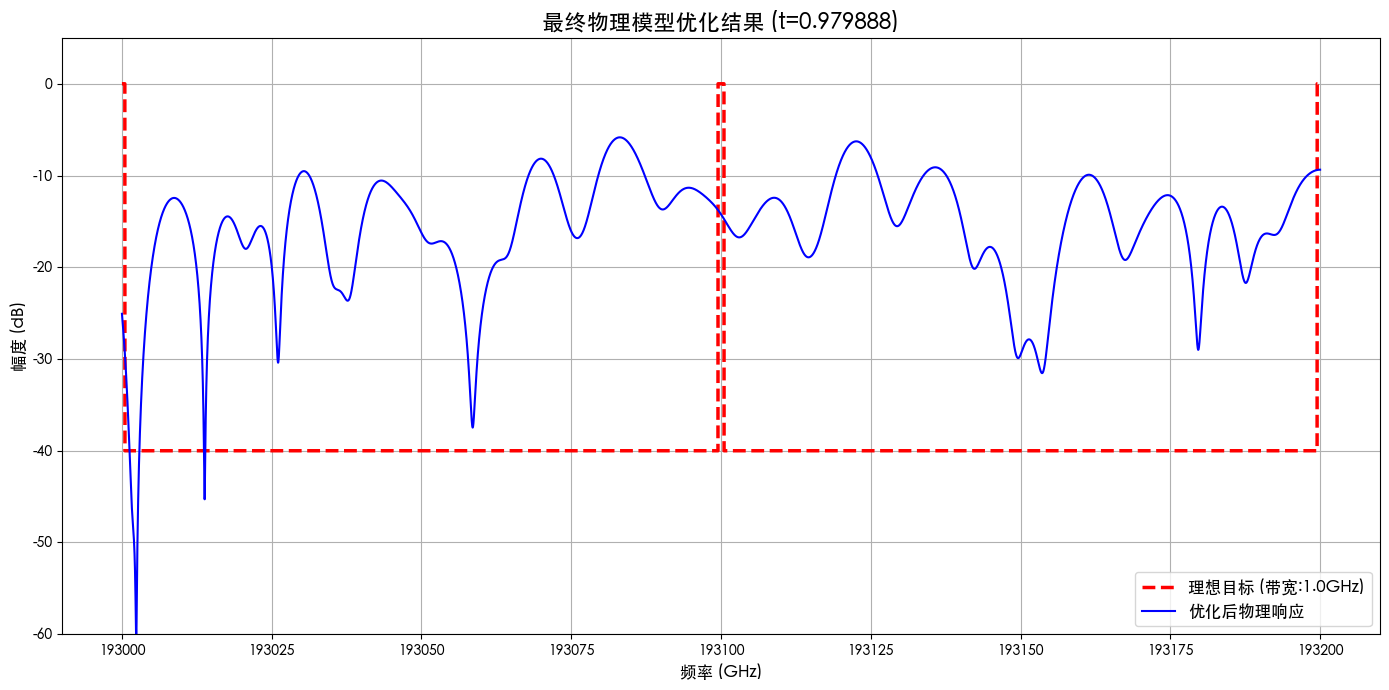

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import time

# ... [tunable_mzi_in, tunable_mzi_out, phase_shifter_matrix, delay_line, objective_function 保持不变] ...
def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def delay_line(f_hz, t, delay, phi_c): # 注意：这里也需要用 f_hz
    # 延迟线可以保持简化，或同样进行物理建模，这里暂不修改
    j = 1j
    return t * np.exp(-j * 2*np.pi*(f_hz-np.mean(f_hz)) * delay - j * phi_c)


# ===================================================================
#           【核心改动 1】基于物理参数的微环传递函数
# ===================================================================
def mrr_transfer_function(f_hz, t, k, L_physical, n_eff, c, phi_offset):
    """
    使用真实的物理参数计算传递函数
    f_hz: 频率数组 (Hz)
    t: 内部传输系数 (损耗)
    k: 耦合系数
    L_physical: 环路物理周长 (m)
    n_eff: 波导有效折射率
    c: 真空光速 (m/s)
    phi_offset: 静态相位偏移
    """
    j = 1j
    # 核心公式：总相位 = (2*pi*f*n_eff/c) * L
    phase = (2 * np.pi * f_hz * n_eff / c) * L_physical + phi_offset
    
    # 您的原始模型（注意这里使用了 t 而非 t**2，更符合标准模型，您可根据需要改回）
    phase_term = np.exp(-j * phase)
    numerator = np.sqrt(1 - k) - t * phase_term
    denominator = 1 - t * np.sqrt(1 - k) * phase_term
    
    return numerator

# ===================================================================
#           【核心改动 2】基于物理参数的光学仿真
# ===================================================================
def optical_simulation(params, t, frequency_hz, H1, H3, n_ku, m_kl, n_eff, c):
    num_rings = n_ku + m_kl
    k_params = params[:num_rings]
    L_params = params[num_rings:] # 现在是 L_physical
    
    ku_k_params, kl_k_params = k_params[:n_ku], k_params[n_ku:]
    ku_L_params, kl_L_params = L_params[:n_ku], L_params[n_ku:]
    
    len_f = len(frequency_hz)

    Au_mrr_responses = [mrr_transfer_function(frequency_hz, t, ku_k_params[i], ku_L_params[i], n_eff, c, phi_offset=0) for i in range(n_ku)]
    Au = np.prod(Au_mrr_responses, axis=0)
    
    if m_kl > 0:
        Al_mrr_responses = [mrr_transfer_function(frequency_hz, t, kl_k_params[i], kl_L_params[i], n_eff, c, phi_offset=0) for i in range(m_kl)]
        Al_mrr_product = np.prod(Al_mrr_responses, axis=0)
    else:
        Al_mrr_product = 1.0

    # 这里的delay line也需要适配，但作为简化，暂时忽略
    Al = Al_mrr_product #* delay_line(frequency_hz, t, delay=1e-12, phi_c=0.0)

    H2_stack = np.zeros((len_f, 2, 2), dtype=complex)
    H2_stack[:, 0, 0], H2_stack[:, 1, 1] = Au, Al
    H_final = H1 @ H2_stack @ H3
    H11 = H_final[:, 0, 0]
    H11_abs = np.abs(H11)
    H11_abs[H11_abs < 1e-15] = 1e-15
    return 20 * np.log10(H11_abs)

def objective_function(params, target_spectrum_db, t, frequency_hz, H1, H3, n_ku, m_kl, n_eff, c):
    simulated_spectrum = optical_simulation(params, t, frequency_hz, H1, H3, n_ku, m_kl, n_eff, c)
    mse_loss = np.mean((simulated_spectrum - target_spectrum_db)**2)
    return mse_loss
    
# ===================================================================
#           【核心改动 3】主程序 - 告别 target_fsr
# ===================================================================
if __name__ == "__main__":
    
    # 1. 物理常量
    c = 299792458.0  # 真空光速 m/s
    n_eff = 2.4      # 波导有效折射率 (典型值，可根据您的材料修改)
    
    # 2. 结构和物理限制
    n_ku = 3
    m_kl = 2
    t = 0.979888 
    
    # 3. 唯一的设计目标！
    target_bandwidth = 1.0e9  # 目标带宽: 1 GHz

    # 4. 仿真和绘图设置
    f_center = 193.1e12
    # 为了绘图和生成目标，我们仍需一个参考FSR，但这不再是优化目标
    # 它只决定了我们的“观测窗口”是多宽
    FSR_for_plotting = 100e9 
    plot_span = 2 * FSR_for_plotting # 绘图的总频率跨度
    
    # 预计算频率数组 (直接使用物理频率)
    frequency_hz = np.linspace(f_center - plot_span / 2, f_center + plot_span / 2, 10000)
    
    # 预计算不变的矩阵 H1 和 H3
    theta_i, theta_o = np.pi/2, np.pi/2
    H1 = tunable_mzi_in(theta_i) @ phase_shifter_matrix(0,0)
    H3 = tunable_mzi_out(theta_o)
    
    # 生成目标频谱 (只为了比较，基于参考FSR)
    print(f"正在生成目标频谱... 带宽 = {target_bandwidth/1e9:.1f} GHz")
    target_spectrum = create_reference_box_filter(
        frequency_array=frequency_hz,
        center_freq=f_center,
        fsr=FSR_for_plotting, # 仅用于生成重复的红色方波
        bandwidth=target_bandwidth,
        passband_level_db=0,
        stopband_level_db=-40
    )
    
    # 更新优化器设置
    num_rings = n_ku + m_kl
    total_params = 2 * num_rings
    bounds_k = [(0.01, 0.99)] * num_rings
    
    # 为物理周长 L_physical 设置合理的边界 (单位: 米)
    # 100GHz FSR -> L ~ 1.25mm; 10GHz FSR -> L ~ 1.25cm
    bounds_L = [(1e-3, 15e-3)] * num_rings # 允许环长在 1mm 到 1.5cm 之间搜索
    bounds = bounds_k + bounds_L

    args_for_optimizer = (target_spectrum, t, frequency_hz, H1, H3, n_ku, m_kl, n_eff, c)

    # 运行差分进化优化器
    print("="*50)
    print(f"开始基于物理模型进行优化... 目标带宽: {target_bandwidth/1e9:.1f}GHz")
    print("="*50)
    
    start_time = time.time()
    result = differential_evolution(
        objective_function, bounds, args=args_for_optimizer, 
        maxiter=300, popsize=30, disp=True,
    )
    end_time = time.time()
    
    print(f"\n优化完成！总耗时: {end_time - start_time:.2f} 秒")
    # ... 结果打印部分 ...
    best_params = result.x
    best_k = best_params[:num_rings]
    best_L = best_params[num_rings:]
    print("\n找到的最优物理参数:")
    for i in range(num_rings):
        # 计算每个环最终的物理FSR
        final_fsr = c / (n_eff * best_L[i])
        print(f"  环 {i+1}: k={best_k[i]:.4f}, L={best_L[i]*1e3:.2f} mm, 对应的FSR={final_fsr/1e9:.2f} GHz")
    
    # 最终效果验证与绘图
    final_spectrum_db = optical_simulation(best_params, t, frequency_hz, H1, H3, n_ku, m_kl, n_eff, c)
    
    plt.figure(figsize=(14, 7))
    plt.plot(frequency_hz / 1e9, target_spectrum, 'r--', lw=2.5, label=f'理想目标 (带宽:{target_bandwidth/1e9:.1f}GHz)')
    plt.plot(frequency_hz / 1e9, final_spectrum_db, 'b-', lw=1.5, label='优化后物理响应')
    plt.title(f'最终物理模型优化结果 (t={t})', fontsize=16)
    plt.xlabel('频率 (GHz)', fontsize=12)
    plt.ylabel('幅度 (dB)', fontsize=12)
    plt.grid(True)
    plt.ylim(-60, 5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()